# Customer Segmentation Project
by: *Dorothy Kunth*

### Notebook 4 - Customer RFM Segmentation using Kmeans Clustering

## Project Overview
The goal is to carry out segmentation of customers using the transaction history of an online gift store occurring between 01/12/2010 and 09/12/2011.

## Project Scope
1. Data Exploration
2. Data Preprocessing
3. Exploratory Data Analysis
4. Customer RFM Segmentation using Percentile Ranking
5. **Customer RFM Segmentation using Kmeans Clustering**

In [31]:
# Import libraries

import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

import warnings
warnings.filterwarnings('ignore')

## Customer Segmentation based on RFM Metrics using Percentile Ranking
To perform customer segmentation using RFM, calculate customer behavior metrics:
1. **Recency** 
        - It measures how recent was each customer's last purchase. 
        - It is the number of days since the last transaction of the customer.
        - The lower it is, the better, since every business wants its customers to be recent and active.
2. **Frequency** 
        - It is a measure of how often customers buy from a company.
        - It calculates the number of orders placed by a customer over a defined period of time.
3. **Monetary Value** 
        - It measures how much has the customer spent within a given period.
        - It is the total value that the customer spent with the company within a given period.

#### Prepare the data
- To calculate recency, frequency, and monetary value, we need the following columns: date, invoice, and total_order_value
- To calculate recency, we need to have the most recent snapshot of data of today or yesterday, but since the data comes from 2010 and 2011, we will have to create a hypothetical snapshot date.

## Customer Segmentation based on RFM Metrics using K-means Clustering
### Key K-means Assumptions:
- 1. Numerical variables only
- 2. Data has no significant number of outliers or noise
- 3. All variables have symmetrical distribution
- 4. Each variable has equal average value and equal variance

#### Task 1 - Load the data

In [2]:
# Load the data

rfm = pd.read_csv('../data/customer_rfm.csv')
rfm

,customer_id,recency,frequency,monetary_value,R,F,M,rfm_segment,rfm_score,customer_segment,campaign_strategy
0,u12347,3,7,4310.00,3,3,3,333,9,Top-performing customers,Send birthday and anniversary cards with di...
1,u12348,76,4,1437.24,2,2,3,223,7,Active customers,Create loyalty rewards program where custo...
2,u12349,19,1,1457.55,3,1,3,313,7,Active customers,Create loyalty rewards program where custo...
3,u1235,311,1,294.40,1,1,1,111,3,Inactive customers,Send personalized emails containing special of...
4,u12352,37,8,1265.41,2,3,3,233,8,Active customers,Create loyalty rewards program where custo...
...,...,...,...,...,...,...,...,...,...,...,...
4346,u1828,278,1,180.60,1,1,1,111,3,Inactive customers,Send personalized emails containing special of...
4347,u18281,181,1,80.82,1,1,1,111,3,Inactive customers,Send personalized emails containing special of...
4348,u18282,8,3,176.60,3,2,1,321,6,Unsteady customers,Send emails with discounted or promotional...
4349,u18283,4,16,2039.58,3,3,3,333,9,Top-performing customers,Send birthday and anniversary cards with di...


In [3]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4351 entries, 0 to 4350
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        4351 non-null   object 
 1   recency            4351 non-null   int64  
 2   frequency          4351 non-null   int64  
 3   monetary_value     4351 non-null   float64
 4   R                  4351 non-null   int64  
 5   F                  4351 non-null   int64  
 6   M                  4351 non-null   int64  
 7   rfm_segment        4351 non-null   int64  
 8   rfm_score          4351 non-null   int64  
 9   customer_segment   4351 non-null   object 
 10  campaign_strategy  4351 non-null   object 
dtypes: float64(1), int64(7), object(3)
memory usage: 374.0+ KB


#### Task 2 - Create a dataframe to only include recency, frequency, and monetary value columns

In [4]:
# Create a dataframe to only include only the recency, frequency, and monetary value columns

rfm_km = rfm[['recency', 'frequency', 'monetary_value']]
rfm_km

,recency,frequency,monetary_value
0,3,7,4310.00
1,76,4,1437.24
2,19,1,1457.55
3,311,1,294.40
4,37,8,1265.41
...,...,...,...
4346,278,1,180.60
4347,181,1,80.82
4348,8,3,176.60
4349,4,16,2039.58


In [5]:
rfm_km.describe()

,recency,frequency,monetary_value
count,4351.000000,4351.000000,4351.000000
mean,93.105493,4.862560,1899.486320
std,101.250679,8.910072,8275.427714
min,1.000000,1.000000,-1192.200000
25%,18.000000,1.000000,294.265000
50%,51.000000,2.000000,644.240000
75%,144.000000,5.000000,1589.095000
max,374.000000,239.000000,278778.020000


#### Check for Outliers

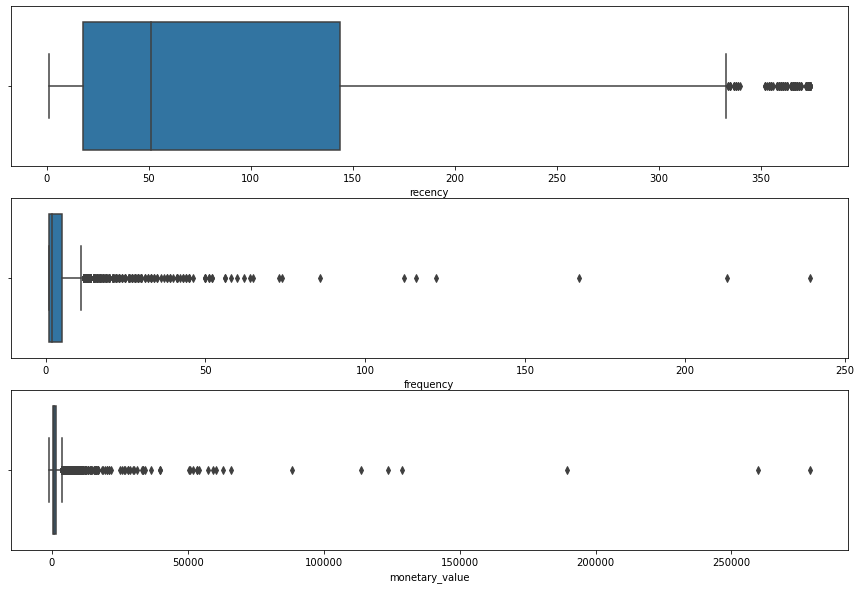

In [6]:
# Create boxplot for each variable
plt.figure(figsize=[15,10])

#plot distribution of recency
plt.subplot(3, 1, 1)
sns.boxplot(rfm_km['recency'])

#plot distribution of frequency
plt.subplot(3, 1, 2)
sns.boxplot(rfm_km['frequency'])

#plot distribution of monetary value
plt.subplot(3, 1, 3)
sns.boxplot(rfm_km['monetary_value'])

plt.show();

> Boxplots show that each of the recency, frequency, and monetary value variables has outliers.

#### Identify Outliers
- Identify outliers using [z-scores](https://articles.outlier.org/z-score-formula-examples-and-how-to-interpret#section-how-to-interpret-zscores) with a z-score >= 3

In [7]:
# Identify outliers

z_scores = stats.zscore(rfm_km)
abs_z_scores = np.abs(z_scores)
filtered_data = (abs_z_scores < 3).all(axis = 1)

In [8]:
# Check how many data points were eliminated (False)

filtered_data.value_counts()

True     4287
False      64
dtype: int64

In [9]:
# Percentage of outliers to total customers

(filtered_data.value_counts()[0]/len(filtered_data)) * 100

1.4709262238565846

> The outliers make up 1% of the total number of customers. I assumed that this won't have a significant impact on clustering, therefore it is not necessary to  exclude them.

In [10]:
rfm_km.head(10)

,recency,frequency,monetary_value
0,3,7,4310.00
1,76,4,1437.24
2,19,1,1457.55
3,311,1,294.40
4,37,8,1265.41
5,205,1,89.00
6,233,1,1079.40
7,215,1,459.40
8,23,3,2487.43
9,34,1,6207.67


#### Visualize the distribution of each variable

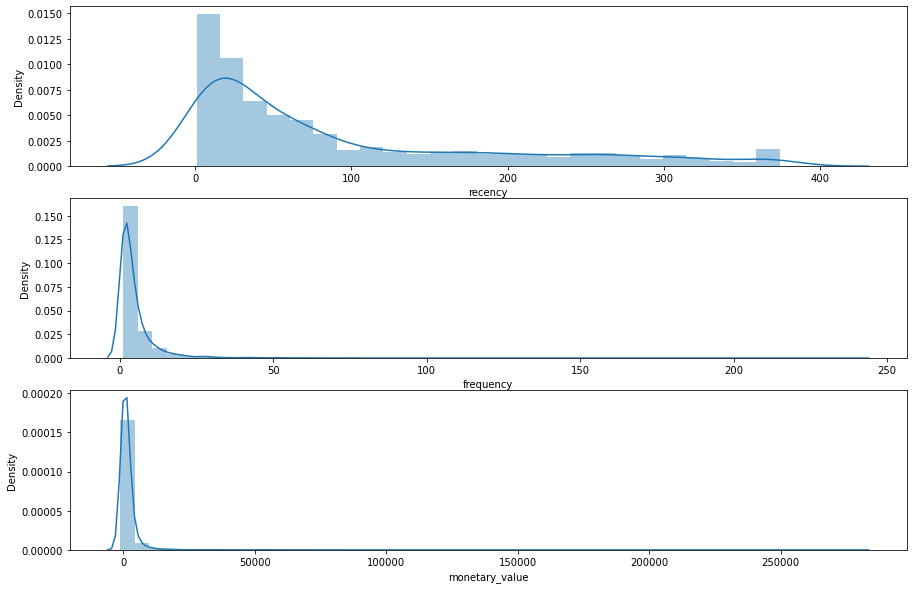

In [11]:
# plot RFM distributions
plt.figure(figsize=[15,10])

#plot distribution of recency
plt.subplot(3, 1, 1)
sns.distplot(rfm_km['recency'])

#plot distribution of frequency
plt.subplot(3, 1, 2)
sns.distplot(rfm_km['frequency'])

#plot distribution of monetary value
plt.subplot(3, 1, 3)
sns.distplot(rfm_km['monetary_value'])

plt.show();

> The distribution of recency, frequency and monetary value metrics are all right skewed.

#### Task 3 - Apply logarithmic transformation to unskew the data
- Logarithmic transformation works only on positive values
- Manage negative values by adding the absolute value of the lowest negative value to each observation, then add a small constant like 1 to force the variables to be strictly positive

In [12]:
# Check for negative values

rfm_km.describe()

,recency,frequency,monetary_value
count,4351.000000,4351.000000,4351.000000
mean,93.105493,4.862560,1899.486320
std,101.250679,8.910072,8275.427714
min,1.000000,1.000000,-1192.200000
25%,18.000000,1.000000,294.265000
50%,51.000000,2.000000,644.240000
75%,144.000000,5.000000,1589.095000
max,374.000000,239.000000,278778.020000


In [13]:
print('The number of observations with negative values in monetary_value variable:', (rfm_km['monetary_value']<0).sum())

The number of observations with negative values in monetary_value variable: 30


In [14]:
# Deal with negative values
# Add the absolute value of the lowest negative value to each monetary values then add 1

rfm_km['monetary_value'] += (1192.20 +1)
rfm_km.describe()

,recency,frequency,monetary_value
count,4351.000000,4351.000000,4351.000000
mean,93.105493,4.862560,3092.686320
std,101.250679,8.910072,8275.427714
min,1.000000,1.000000,1.000000
25%,18.000000,1.000000,1487.465000
50%,51.000000,2.000000,1837.440000
75%,144.000000,5.000000,2782.295000
max,374.000000,239.000000,279971.220000


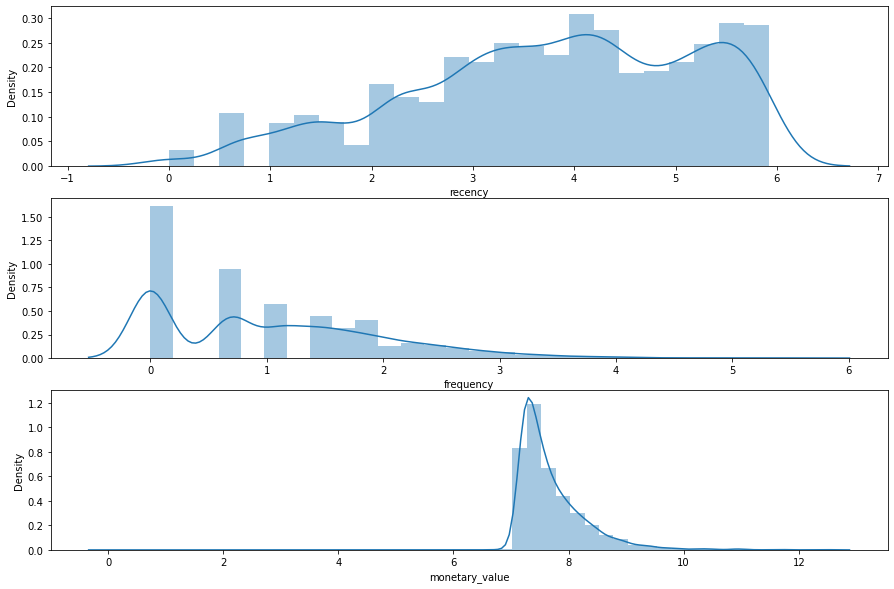

In [15]:
# Unskew the data
rfm_km_log = np.log(rfm_km)

# plot transfomed RFM distributions
plt.figure(figsize=[15,10])

#plot distribution of recency
plt.subplot(3, 1, 1)
sns.distplot(rfm_km_log['recency'])

#plot distribution of frequency
plt.subplot(3, 1, 2)
sns.distplot(rfm_km_log['frequency'])

#plot distribution of monetary value
plt.subplot(3, 1, 3)
sns.distplot(rfm_km_log['monetary_value'])

plt.show();

> The distributions are not perfectly symmetrical, there are still some skewness but not very skewed compared to the original distribtuion.

#### Task 4 - Center and scale the variables
As K-means works well on variables with the same mean and variance:
- 1. Centering can be done by manually subtracting the average value from each observation 
- 2. Scaling can be done by dividing each observation by standard deviation of each
- 3. Alternatively, a built-in function StandardScaler() from scikit-learn library can be used to normalize the variables

In [16]:
rfm_km_log.describe()

,recency,frequency,monetary_value
count,4351.000000,4351.000000,4351.000000
mean,3.774762,1.034731,7.701664
std,1.411754,0.945102,0.602236
min,0.000000,0.000000,0.000000
25%,2.890372,0.000000,7.304829
50%,3.931826,0.693147,7.516129
75%,4.969813,1.609438,7.931031
max,5.924256,5.476464,12.542442


In [17]:
# Initialize StandardScaler and fit

scaler = StandardScaler()
scaler.fit(rfm_km_log)

# Transform and store the scaled data for clustering
rfm_km_normalized = scaler.transform(rfm_km_log)
rfm_km_normalized = pd.DataFrame(data=rfm_km_normalized, index=rfm_km_log.index, columns=rfm_km_log.columns)
rfm_km_normalized.describe().round(2)

,recency,frequency,monetary_value
count,4351.00,4351.00,4351.00
mean,-0.00,0.00,-0.00
std,1.00,1.00,1.00
min,-2.67,-1.09,-12.79
25%,-0.63,-1.09,-0.66
50%,0.11,-0.36,-0.31
75%,0.85,0.61,0.38
max,1.52,4.70,8.04


> Now each variable has an average of zero and standard deviation of 1

#### Task 5 - Build elbow criterion plot
- Use elbow criterion method to choose the number of clusters
- The elbow criterion method plots the sum of squared errors (SSE) for each number of segments which is basically the sum of squared distances from each data point to their cluster center. 
- Identify an elbow in the plot - which represents the optimal number of clusters

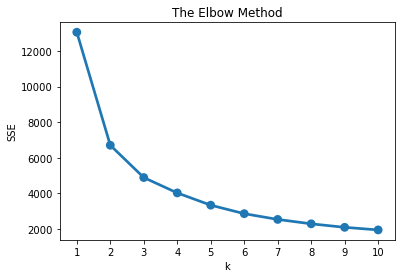

In [18]:
# Fit KMeans and calculate sum of squared errors for each k

# empty dictionary for sum squared of errors
sse = {} 

# run for loop over different number of clusters between 1 and 10 to buils kmeans segmentation on rfm_km_normalized
for k in range(1, 11): 
    
    #initialize K-means with k clusters and fit it
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(rfm_km_normalized)
    
    # assign sum of squared distance to k element of the sse dictionary
    sse[k] = kmeans.inertia_ # sum of squared distances to closest cluster center

# plot SSE for each k
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show();

> - The elbow criterion plot shows point 2 is where we identify the largest angle, suggesting 2 clusters.
> - Identifying the number of clusters based on where the elbow is formed is not a hard rule. It is recommended to use experimental approach to choose the optimal number of clusters by calculating the average RFM and compare the results to identify the number of clusters that is most useful and provides the most insight.
> - For the purpose of this segmentation, we will build segments based on 2, 3, and 4 clusters and compare the outputs.

#### Task 6 - Silhouette Analysis
- The silhouette score is a measure of how close each sample in one cluster is to the samples in the neighboring clusters.
- It ranges from -1 to 1, and a higher value indicates that samples are well clustered.

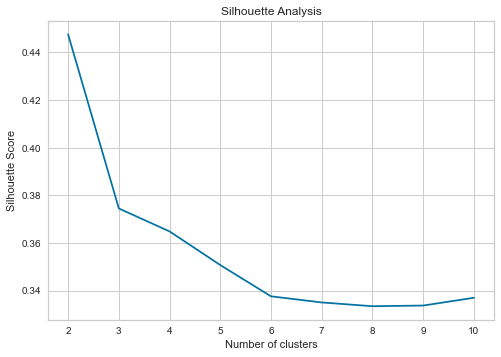

In [35]:
ave_sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k, random_state = 0).fit(rfm_km_normalized)
  labels = kmeans.labels_
  ave_sil.append(silhouette_score(rfm_km_normalized, labels, metric = 'euclidean'))

plt.plot(range(2, 11), sil)
plt.title('Silhouette Analysis')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

> According to the Silhouette Analysis, 2-cluster is the optimal number.

#### Silhouette plot of a model with 2 cluster

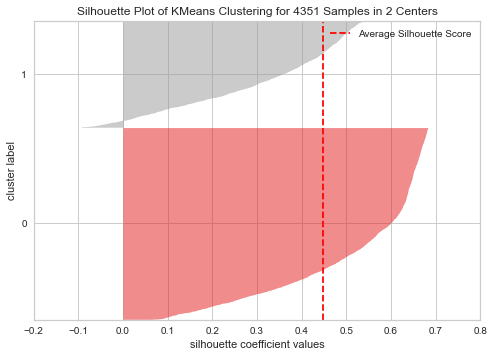

# of clusters: 2
Silhouette score 0.4475319914490562


In [36]:
silh = SilhouetteVisualizer(KMeans(2, random_state = 0))
silh.fit(rfm_km_normalized)
silh.poof()
print("# of clusters:", silh.n_clusters_)
print("Silhouette score", silh.silhouette_score_)

#### Silhouette plot of a model with 3 cluster

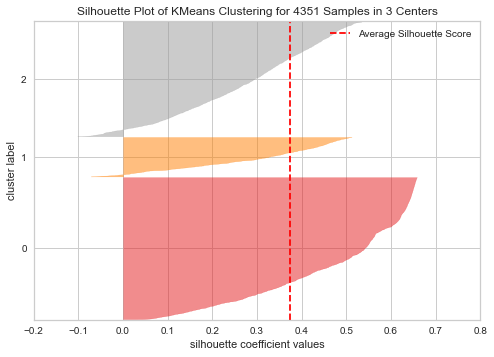

# of clusters: 3
Silhouette score 0.3744478552182378


In [34]:
silh = SilhouetteVisualizer(KMeans(3, random_state = 0))
silh.fit(rfm_km_normalized)
silh.poof()
print("# of clusters:", silh.n_clusters_)
print("Silhouette score", silh.silhouette_score_)

#### Task 7 - Run Kmeans

#### Run K-means using 2 clusters

In [19]:
kmeans = KMeans(n_clusters = 2, random_state = 1)

# Fit k-means clustering on the data
kmeans.fit(rfm_km_normalized)

#extract cluster labels
cluster_labels_2 = kmeans.labels_

In [20]:
# Create a cluster label column in the rfm_km data

rfm_km = rfm_km.assign(cluster2 = cluster_labels_2)

# Group data by cluster and calculate average rfm values and segment sizes per cluster
rfm_km.groupby(['cluster2']).agg({   
    'recency': 'mean',
    'frequency': 'mean',
    'monetary_value': ['mean', 'count']
}).round(2).sort_values(by=('recency', 'mean'))

recency frequency monetary_value      
            mean      mean           mean count
cluster2                                       
0          23.50     10.22        5641.34  1543
1         131.35      1.92        1692.20  2808

> Based on 2-cluster solution:
    > - Cluster 1 could be profiled as **wholesalers** with average recency of 23 days, average frequency of 10 times, and average spend of \$5600.
    > - Cluster 0 could be profiled as **individual customers** with average recency of 131 days, average frequency of 2 time(s) and average spend of \$1600

#### Run K-means using 3 clusters

In [21]:
kmeans = KMeans(n_clusters = 3, random_state = 1)

# Fit k-means clustering on the data
kmeans.fit(rfm_km_normalized)

#extract cluster labels
cluster_labels_3 = kmeans.labels_

In [22]:
# Create a cluster label column in the rfm_km data

rfm_km = rfm_km.assign(cluster3 = cluster_labels_3)

# Group data by cluster and calculate average rfm values and segment sizes per cluster
rfm_km.groupby(['cluster3']).agg({   
    'recency': 'mean',
    'frequency': 'mean',
    'monetary_value': ['mean', 'count']
}).round(2).sort_values(by=('recency', 'mean'))

recency frequency monetary_value      
            mean      mean           mean count
cluster3                                       
2          15.71     17.88       10357.04   579
1          34.48      4.51        2435.68  1687
0         162.04      1.54        1606.98  2085

> Based on 3-cluster solution:
    > - Cluster 2 could be profiled as **active customers** with average recency of 15 days, average frequency of 18 times, and average spend of \$10000.
    > - Cluster 0 could be profiled as **unsteady customers** with average recency of 34 days, average frequency of 4 times and average spend of \$2400
    > - Cluster 1 could be profiled as **inactive customers** with average recency of 162 days, average frequency of 1 time(s) and average spend of \$1500

#### Run K-means using 4 clusters

In [23]:
kmeans = KMeans(n_clusters = 4, random_state = 1)

# Fit k-means clustering on the data
kmeans.fit(rfm_km_normalized)

#extract cluster labels
cluster_labels_4 = kmeans.labels_

In [24]:
# Create a cluster label column in the rfm_km data

rfm_km = rfm_km.assign(cluster4 = cluster_labels_4)

# Group data by cluster and calculate average rfm values and segment sizes per cluster
rfm_km.groupby(['cluster4']).agg({   
    'recency': 'mean',
    'frequency': 'mean',
    'monetary_value': ['mean', 'count']
}).round(2).sort_values(by=('recency', 'mean'))

recency frequency monetary_value      
            mean      mean           mean count
cluster4                                       
2          11.54     18.84       11015.39   515
3          15.86      2.82        1872.77   914
0          59.72      5.80        2953.56  1061
1         172.65      1.47        1578.67  1861

> Based on 4-cluster solution:
    > - Cluster 3 could be profiled as **top customers:** 
        - most current, most frequent and highest spend
    > - Cluster 1 could be profiled as **emerging customers:**
        - 2nd most current but 3rd most frequent and 3rd highest spend
        - current, but rare and low spend
    > - Cluster 0 could be profiled as **unsteady/at risk customers:** 
        - recency of 2 months, buys products 5 times/year and average spend of $2900 
        - not current, but more frequent and higher spend than the emerging customers
    > - Cluster 2 could be profiled as **inactive customers:** 
        - not current, rare, and low spend

### Based on the average RFM, while 2-cluster appears to be the optimal number based on both the elbow and silhouette methods, the 3-cluster solution gives better insights. 

In [25]:
rfm_km

,recency,frequency,monetary_value,cluster2,cluster3,cluster4
0,3,7,5503.20,0,2,2
1,76,4,2630.44,1,1,0
2,19,1,2650.75,1,1,3
3,311,1,1487.60,1,0,1
4,37,8,2458.61,0,1,0
...,...,...,...,...,...,...
4346,278,1,1373.80,1,0,1
4347,181,1,1274.02,1,0,1
4348,8,3,1369.80,1,1,3
4349,4,16,3232.78,0,2,2


#### Task 8 - Create a dataframe to merge cluster3 values to rfm dataframe

In [26]:
# Merge the cluster values to rfm dataset
cluster3 = pd.DataFrame(cluster_labels_3).rename(columns={0: 'cluster'})
customer_segments_km = pd.concat([rfm, cluster3], axis=1)
customer_segments_km

,customer_id,recency,frequency,monetary_value,R,F,M,rfm_segment,rfm_score,customer_segment,campaign_strategy,cluster
0,u12347,3,7,4310.00,3,3,3,333,9,Top-performing customers,Send birthday and anniversary cards with di...,2
1,u12348,76,4,1437.24,2,2,3,223,7,Active customers,Create loyalty rewards program where custo...,1
2,u12349,19,1,1457.55,3,1,3,313,7,Active customers,Create loyalty rewards program where custo...,1
3,u1235,311,1,294.40,1,1,1,111,3,Inactive customers,Send personalized emails containing special of...,0
4,u12352,37,8,1265.41,2,3,3,233,8,Active customers,Create loyalty rewards program where custo...,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4346,u1828,278,1,180.60,1,1,1,111,3,Inactive customers,Send personalized emails containing special of...,0
4347,u18281,181,1,80.82,1,1,1,111,3,Inactive customers,Send personalized emails containing special of...,0
4348,u18282,8,3,176.60,3,2,1,321,6,Unsteady customers,Send emails with discounted or promotional...,1
4349,u18283,4,16,2039.58,3,3,3,333,9,Top-performing customers,Send birthday and anniversary cards with di...,2


In [27]:
# Include only the recency, fequency, and monetary value, and cluster columns
customer_segments_km = customer_segments_km[['customer_id', 'recency', 'frequency', 'monetary_value', 'cluster']]
customer_segments_km

,customer_id,recency,frequency,monetary_value,cluster
0,u12347,3,7,4310.00,2
1,u12348,76,4,1437.24,1
2,u12349,19,1,1457.55,1
3,u1235,311,1,294.40,0
4,u12352,37,8,1265.41,1
...,...,...,...,...,...
4346,u1828,278,1,180.60,0
4347,u18281,181,1,80.82,0
4348,u18282,8,3,176.60,1
4349,u18283,4,16,2039.58,2


In [28]:
# Use cluster to group customer into named segments

customer_segments_km.loc[customer_segments_km['cluster'] == 2, \
    ['customer_segment', 'campaign_strategy']] = 'Active customers','Send birthday and anniversary cards \
    with discount vouchers. Create a referral program where customers can get discounts on the first purchase \
    of their referrals.'
customer_segments_km.loc[customer_segments_km['cluster'] == 0, \
    ['customer_segment', 'campaign_strategy']] = 'Unsteady customers', "Send emails with discounted or \
    promotional items for every occasion, including birthdays, Mother's Day, Father's Day, and Christmas."

customer_segments_km.loc[customer_segments_km['cluster'] == 1, \
    ['customer_segment', 'campaign_strategy']] = 'Inactive customers', 'Send personalized emails containing special offers\
    with discounted or free items to encourage them to order and be active.'

customer_segments_km

,customer_id,recency,frequency,monetary_value,cluster,customer_segment,campaign_strategy
0,u12347,3,7,4310.00,2,Active customers,Send birthday and anniversary cards with d...
1,u12348,76,4,1437.24,1,Inactive customers,Send personalized emails containing special of...
2,u12349,19,1,1457.55,1,Inactive customers,Send personalized emails containing special of...
3,u1235,311,1,294.40,0,Unsteady customers,Send emails with discounted or promotional...
4,u12352,37,8,1265.41,1,Inactive customers,Send personalized emails containing special of...
...,...,...,...,...,...,...,...
4346,u1828,278,1,180.60,0,Unsteady customers,Send emails with discounted or promotional...
4347,u18281,181,1,80.82,0,Unsteady customers,Send emails with discounted or promotional...
4348,u18282,8,3,176.60,1,Inactive customers,Send personalized emails containing special of...
4349,u18283,4,16,2039.58,2,Active customers,Send birthday and anniversary cards with d...


#### Visualize customers per segment

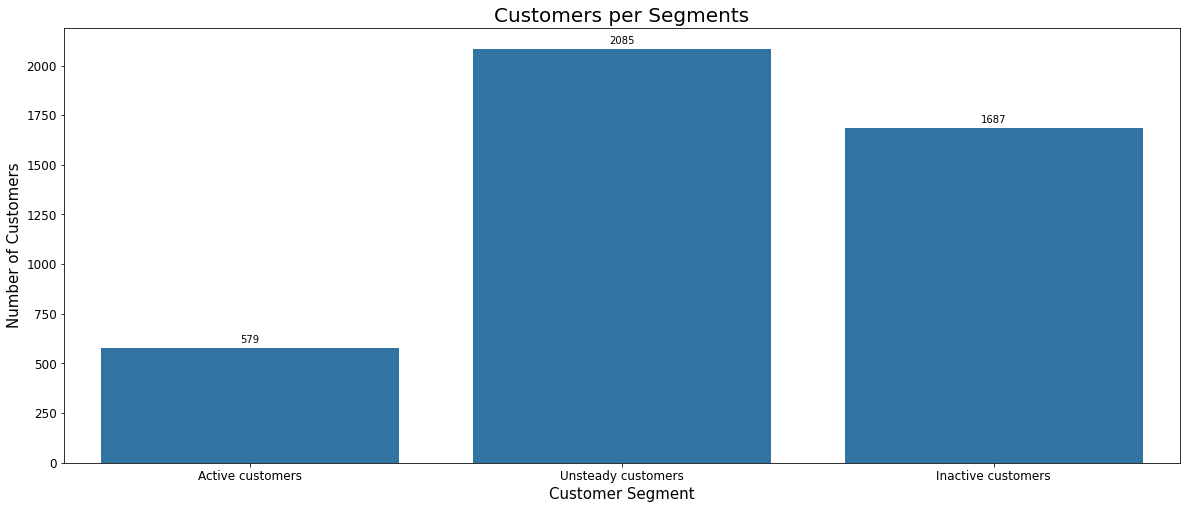

In [29]:
cust_segment = customer_segments_km.groupby(['customer_segment'])['customer_id'].nunique()

plt.figure(figsize = [20, 8])
base_color = sns.color_palette()[0]
cat_order = ['Active customers', 'Unsteady customers', 'Inactive customers']

ax = sns.barplot(x = cust_segment.index, y = cust_segment.values, color = base_color, order = cat_order)
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
ax.bar_label(ax.containers[0], padding = 3)

plt.title('Customers per Segments', size=20)
plt.xlabel('Customer Segment', size = 15)
plt.ylabel('Number of Customers', size = 15)

plt.show();

#### Conclusion:

- The result of segmentation based on RFM metrics using percentile ranking is better than using Kmeans clustering.
- The segmentation using percentile ranking gives more insights and is more useful to understand each segment's unique needs and tailor the products and campaign strategies to better meet those needs.